## Multifactor model for daily stock returns
##### szli@github, szli.code@gmail.com

This exercise estimates BARRA factor model returns. More specifically,
* The BARRA factor loading data and daily stock return data are given.
* For simplicity, the analysis is limited to top around 600 stocks in market cap factor. 
* Use cross sectional regressions to estimate factor returns, i.e., estimate factor returns $f_t$ given stock returns $R_t$ and factor loadings $B$ in the following: $R_t = Bf_t + \epsilon_t$, for each day $t$.

Here is a good reference for this topic: http://faculty.washington.edu/ezivot/research/factormodellecture_handout.pdf

In [1]:
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
print(sys.version)
print(pd.version.version)
print(np.version.version)

3.4.3 |Anaconda 2.3.0 (64-bit)| (default, Mar  6 2015, 12:06:10) [MSC v.1600 64 bit (AMD64)]
0.16.2
1.9.2


### Load data, put factor loading and return data in good shape

In [3]:
rawfactorcsv = pd.read_csv('./factor_loading.csv')
rawfactorcsv.rename(columns = {name: name.strip() for name in rawfactorcsv.columns}, inplace=True) #columns names have trailing spaces

In [4]:
#Sort by CAPITALIZAION, pick first 1000 stocks, and set TICKER to be the index
sortedfactorcsv = rawfactorcsv.sort(columns='CAPITALIZATION', ascending=False)
sortedfactorcsv = sortedfactorcsv.set_index('TICKER', verify_integrity=True).iloc[:1000]

In [5]:
#Only pick 12 factors, and clear the trailing spaces in the ticker
factors = sortedfactorcsv[['VOLTILTY','MOMENTUM','SIZE','SIZENONL','TRADEACT','GROWTH','EARNYLD','VALUE','EARNVAR','LEVERAGE', 'CURRSEN','YIELD']]
factors = factors.rename(index={sym:sym.strip() for sym in factors.index})

In [6]:
factors

,VOLTILTY,MOMENTUM,SIZE,SIZENONL,TRADEACT,GROWTH,EARNYLD,VALUE,EARNVAR,LEVERAGE,CURRSEN,YIELD
TICKER,,,,,,,,,,,,
AAPL,0.152,-1.227,1.849,0.197,0.823,1.505,0.763,-0.334,0.155,-1.264,0.376,0.142
XOM,-1.107,-0.560,1.835,0.197,-0.599,-0.078,0.850,0.016,-0.102,-1.552,-0.021,0.286
GOOG,-0.807,0.234,1.573,0.197,-0.462,0.774,-0.308,-0.436,-0.280,-1.164,0.583,-1.050
MSFT,0.287,-0.580,1.495,0.197,-0.694,0.044,0.556,-0.418,-0.175,-1.426,-0.067,0.423
JNJ,-0.735,0.159,1.486,0.197,-0.464,-0.280,-0.078,-0.426,-0.551,-1.370,0.273,0.455
GE,-0.023,-0.565,1.455,0.197,-0.312,-0.972,0.239,0.280,-0.469,1.077,-0.589,0.563
WMT,-1.073,-0.554,1.465,0.197,-0.875,-0.364,0.281,-0.274,-0.520,-0.659,-0.454,0.676
CVX,-0.931,-0.278,1.431,0.197,-0.610,-0.394,1.135,0.488,0.188,-1.131,-0.285,0.489
WFC,0.110,-0.004,1.388,0.197,-0.123,0.641,0.705,0.689,0.198,-0.066,-1.052,0.329


In [7]:
stocks = factors.index
stocks

Index(['AAPL', 'XOM', 'GOOG', 'MSFT', 'JNJ', 'GE', 'WMT', 'CVX', 'WFC', 'CHL', 
       ...
       'LKQ', 'BKEAF', 'ADT', 'VOPKY', 'CGEMY', 'MGM', 'WGP', 'ZODFY', 'EQIX',
       'AUY'],
      dtype='object', name='TICKER', length=1000)

Actually there are lots of symbols missing in price data, only 616 has data.... missing are on OTC markets...

In [8]:
from os import listdir
pricefiles = listdir('./price_data_2013/')

In [9]:
prices_date = {}
for pricefile in pricefiles:
    pricecsv = pd.read_csv('./price_data_2013/' + pricefile, sep = "\t")
    pricecsv.set_index('ticker', verify_integrity=True, inplace=True)    
    t = pricefile.split('.')[1]
    #only pick the stocks that are in 1000 stocks list, only use adjClose column, drop NaN rows (ticker in stocks but not in price files)
    prices_date[t] = pricecsv.loc[stocks].dropna()['adjClose']

In [10]:
pricecsv.loc[stocks]

,symid,open,high,low,close,volume,adjClose
TICKER,,,,,,,
AAPL,108,478.45,489.1400,478.3810,488.03,12638665,488.03
XOM,627,85.90,86.3400,85.7800,86.00,11888460,86.00
GOOG,8302,880.25,887.6700,880.0500,887.63,1685208,887.63
MSFT,171,33.34,33.6100,33.3000,33.58,36718733,33.58
JNJ,421,86.52,87.4900,86.2600,87.47,6320028,87.47
GE,378,23.94,24.2200,23.9000,24.17,28989664,24.17
WMT,618,73.86,73.8900,73.3200,73.59,5683089,73.59
CVX,315,121.19,121.7400,120.8400,121.32,4703384,121.32
WFC,611,41.34,41.5699,41.0900,41.49,12776689,41.49


In [11]:
pricesDF = pd.DataFrame(prices_date).T

In [12]:
pricesDF

,A,AAPL,AAUKY,ABB,ABBV,ABC,ABT,ABV,ABX,ACE,...,WY,WYNN,XEL,XLNX,XOM,XRX,YHOO,YUM,ZMH,ZTS
20130903,46.93,488.58,11.97,21.58,42.59,57.39,32.93,34.57,19.51,88.28,...,27.10,141.68,27.49,44.62,87.15,10.12,27.78,70.00,78.91,29.43
20130904,47.87,498.76,11.98,22.00,43.13,58.13,33.46,34.35,19.41,88.23,...,27.10,141.38,27.34,45.84,87.76,10.01,28.07,69.63,79.44,29.69
20130905,47.68,495.27,12.31,21.99,43.51,58.15,33.74,35.20,18.91,88.19,...,27.76,142.69,27.27,46.11,87.35,10.06,28.23,69.84,79.60,30.33
20130906,47.43,498.22,12.34,22.23,43.89,58.24,33.50,35.38,19.08,88.19,...,28.51,143.43,27.37,46.18,87.25,10.03,28.17,69.61,79.88,30.61
20130909,47.95,506.18,12.50,22.61,44.43,58.66,33.80,36.16,19.20,89.50,...,28.95,145.35,27.46,46.33,88.04,10.08,29.23,71.48,80.70,30.59
20130910,48.55,494.65,12.79,22.82,44.78,59.37,34.09,36.70,18.44,90.01,...,28.78,149.24,27.72,46.97,87.82,10.22,29.48,71.53,80.85,30.95
20130911,48.96,467.83,12.68,23.05,44.95,60.49,34.75,37.21,18.64,92.22,...,28.43,150.87,27.64,46.96,88.84,10.29,29.19,72.21,80.84,31.33
20130912,48.62,472.69,12.73,23.04,44.70,60.46,34.76,37.10,17.61,91.05,...,28.32,149.65,27.56,47.11,87.98,10.14,29.65,72.39,81.24,31.08
20130913,48.46,464.90,12.47,22.91,44.89,60.28,34.87,37.02,17.72,91.67,...,28.39,150.35,27.64,47.25,88.40,10.45,29.26,72.53,81.89,31.05
20130916,48.74,450.12,12.52,23.13,45.82,60.95,35.01,37.07,18.14,92.40,...,28.77,149.98,27.40,47.50,88.67,10.40,29.62,72.65,82.82,31.85


In [13]:
#Columns with NaN prices
pd.isnull(pricesDF).any(0).nonzero()[0]

array([ 26,  87,  95, 153, 160, 242, 262, 313, 342, 348, 431, 474, 587], dtype=int64)

In [14]:
pricesDF.iloc[:, 87]

20130903    31.85
20130904    32.15
20130905      NaN
20130906    32.61
20130909    33.10
20130910    33.71
20130911    33.78
20130912    33.51
20130913    33.38
20130916    33.75
20130917    33.80
20130918    34.80
20130919    34.59
20130920    34.26
20130923    34.36
20130924    34.40
20130925    34.65
20130926    34.23
20130927      NaN
20130930    33.85
20131001    34.30
Name: BNPQY, dtype: float64

In [15]:
#Drop those NaN columns
pricesDF.dropna(1, inplace=True)

In [16]:
returnDF = pricesDF.pct_change()

In [17]:
returnDF

,A,AAPL,AAUKY,ABB,ABBV,ABC,ABT,ABV,ABX,ACE,...,WY,WYNN,XEL,XLNX,XOM,XRX,YHOO,YUM,ZMH,ZTS
20130903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20130904,0.020030,0.020836,0.000835,0.019462,0.012679,0.012894,0.016095,-0.006364,-0.005126,-0.000566,...,0.000000,-0.002117,-0.005457,0.027342,0.006999,-0.010870,0.010439,-0.005286,0.006717,0.008835
20130905,-0.003969,-0.006997,0.027546,-0.000455,0.008811,0.000344,0.008368,0.024745,-0.025760,-0.000453,...,0.024354,0.009266,-0.002560,0.005890,-0.004672,0.004995,0.005700,0.003016,0.002014,0.021556
20130906,-0.005243,0.005956,0.002437,0.010914,0.008734,0.001548,-0.007113,0.005114,0.008990,0.000000,...,0.027017,0.005186,0.003667,0.001518,-0.001145,-0.002982,-0.002125,-0.003293,0.003518,0.009232
20130909,0.010964,0.015977,0.012966,0.017094,0.012303,0.007212,0.008955,0.022046,0.006289,0.014854,...,0.015433,0.013386,0.003288,0.003248,0.009054,0.004985,0.037629,0.026864,0.010265,-0.000653
20130910,0.012513,-0.022778,0.023200,0.009288,0.007878,0.012104,0.008580,0.014934,-0.039583,0.005698,...,-0.005872,0.026763,0.009468,0.013814,-0.002499,0.013889,0.008553,0.000699,0.001859,0.011769
20130911,0.008445,-0.054220,-0.008600,0.010079,0.003796,0.018865,0.019361,0.013896,0.010846,0.024553,...,-0.012161,0.010922,-0.002886,-0.000213,0.011615,0.006849,-0.009837,0.009507,-0.000124,0.012278
20130912,-0.006944,0.010388,0.003943,-0.000434,-0.005562,-0.000496,0.000288,-0.002956,-0.055258,-0.012687,...,-0.003869,-0.008086,-0.002894,0.003194,-0.009680,-0.014577,0.015759,0.002493,0.004948,-0.007980
20130913,-0.003291,-0.016480,-0.020424,-0.005642,0.004251,-0.002977,0.003165,-0.002156,0.006246,0.006809,...,0.002472,0.004678,0.002903,0.002972,0.004774,0.030572,-0.013153,0.001934,0.008001,-0.000965
20130916,0.005778,-0.031792,0.004010,0.009603,0.020717,0.011115,0.004015,0.001351,0.023702,0.007963,...,0.013385,-0.002461,-0.008683,0.005291,0.003054,-0.004785,0.012303,0.001654,0.011357,0.025765


In [18]:
returnDF.dropna(inplace=True) #Drop first row, all NaN

In [19]:
#Only keep stocks that have price data in factor loading matrix, and reorder the matrix according to the ordering in return data
factors_trim = factors.loc[returnDF.columns]
factors_trim

,VOLTILTY,MOMENTUM,SIZE,SIZENONL,TRADEACT,GROWTH,EARNYLD,VALUE,EARNVAR,LEVERAGE,CURRSEN,YIELD
A,0.144,-0.506,-0.653,0.076,0.823,-0.245,0.186,-0.164,-0.244,-0.036,0.653,-0.505
AAPL,0.152,-1.227,1.849,0.197,0.823,1.505,0.763,-0.334,0.155,-1.264,0.376,0.142
AAUKY,1.777,-2.338,-0.155,0.102,-2.148,-1.541,0.982,2.547,2.964,0.185,0.977,0.039
ABB,0.153,-0.360,0.250,0.104,-1.565,-0.274,0.184,-0.179,-0.467,-0.477,0.116,0.223
ABBV,0.244,0.356,0.511,0.115,-0.160,0.575,0.433,-1.012,-0.511,0.635,0.041,0.652
ABC,-0.241,0.634,-0.755,0.061,1.042,0.055,0.034,-0.614,-0.479,-0.597,0.212,-0.236
ABT,-0.436,-0.268,0.335,0.106,-0.282,-0.626,-0.112,0.221,-0.371,-0.081,0.334,0.099
ABV,0.068,-0.329,0.264,0.104,-1.211,-0.275,-0.438,-0.436,-0.262,-0.719,1.078,-0.254
ABX,3.166,-2.928,-0.579,0.084,1.621,0.145,0.597,2.615,3.957,0.625,0.833,0.631
ACE,-0.674,0.017,-0.123,0.102,-0.390,-0.523,0.889,1.443,-0.274,-0.706,-0.669,0.128


### Cross-sectional regression:
Note that we have heteroskedasticity in error terms, so first need to estimate the variance of the error term. We assume the error terms for each stock are uncorrelated, so the covariance matrix of the error terms will be diagnal. There are multiple ways to estimate error variance, I use two of them.

1. Method 1: Perform OLS on every day, compute the residual $\hat{\epsilon}_t = R_t - B\hat{f_t}$ on every day, then use the sample variance of the residuals $\hat{\epsilon}_t$ across days as the estimate of the error variance, and perform Weighted Least Square using weights 1/variance_estimate
2. Method 2: Perform OLS on every day, then run the OLS linear regression below for every day
$$log(\hat{\epsilon}^2_t) = g_{0t} + BG_t + e_t$$
where $\hat{\epsilon}_t$ is the residual from OLS, $B$ is the factor loading matrix, used as the predictor of log variance (taking log to make sure estimated variance always non-negative). Then compute the fitted value of log variance: $B\hat{G}_t$, this gives the estimate of log variance on every day, take expontial to get the estimate of variance every day then average over days. Then, perform WLS using weights 1/variance_estimate. 

Comparing the estimated factor return using the two methods, they have similar trends over time, although the magnitudes are a bit different. 

In [20]:
import numpy.linalg

In [21]:
#returnDF is T by N, so need transpose, T = 20 days, N = 600+ stocks, P = 12 factors
#Do OLS for all days
OLS_factor_result = np.linalg.lstsq(factors_trim.values, returnDF.values.T) 

In [22]:
OLS_factor_returns = OLS_factor_result[0]

OLS_factor_returns.shape #P by T

(12, 20)

In [23]:
#Note the dimensions: N-by-T -  N-by-P * P-by-T
OLS_residues = returnDF.values.T - factors_trim.values.dot(OLS_factor_returns)

#### Method One: 

In [24]:
var_est = np.var(OLS_residues, 1, ddof = 1)

In [25]:
var_est

array([  1.44518523e-04,   5.39859969e-04,   2.34743233e-04,
         3.32410946e-05,   1.92641861e-04,   4.59549380e-05,
         9.09122951e-05,   8.64002801e-05,   5.26828020e-04,
         7.26463084e-05,   1.01456649e-04,   1.66818041e-04,
         3.51054031e-04,   3.76285704e-05,   5.63383763e-05,
         2.82553661e-05,   7.34882088e-05,   2.09348655e-04,
         1.37848411e-04,   7.50078838e-05,   8.72018911e-05,
         1.20051281e-04,   2.93297344e-05,   1.67047197e-04,
         2.99337905e-04,   1.95024361e-04,   3.93304616e-05,
         1.21069671e-04,   1.48277904e-04,   7.82115453e-05,
         1.26939510e-04,   7.42313860e-05,   5.03057896e-04,
         8.75739127e-05,   3.30917725e-05,   1.25443234e-04,
         2.28601030e-05,   1.79579437e-04,   2.21281110e-04,
         1.28247248e-04,   8.76036216e-05,   1.78065195e-04,
         3.31605839e-05,   8.40095452e-05,   9.90269867e-05,
         6.76723341e-05,   3.32638446e-04,   1.48718775e-04,
         6.98269983e-05,

In [26]:
WLS_weights = 1/var_est

In [27]:
import statsmodels.api as sm

In [28]:
WLS_results = {}
for row in returnDF.iterrows(): #row[1] is the Series, row[0] is the row name
    WLS_model = sm.WLS(row[1].values, factors_trim.values, weights = WLS_weights)
    WLS_results[row[0]] = WLS_model.fit()

In [29]:
WLS_factor_return = {day: WLS_results[day].params for day in WLS_results}

In [30]:
WLS_factor_returnDF = pd.DataFrame(data = WLS_factor_return, index = factors_trim.columns).T

In [31]:
WLS_factor_returnDF

,VOLTILTY,MOMENTUM,SIZE,SIZENONL,TRADEACT,GROWTH,EARNYLD,VALUE,EARNVAR,LEVERAGE,CURRSEN,YIELD
20130904,0.003483,0.000320,-0.006277,0.073501,-0.000366,-0.000801,0.001535,-0.000593,-0.000477,-0.001964,-0.001174,-0.002722
20130905,0.001126,-0.001040,-0.001827,0.017043,-0.000406,0.000130,0.001700,0.000807,0.001140,-0.001041,-0.000187,-0.002142
20130906,0.000320,-0.003265,-0.001042,0.008561,-0.001409,0.001257,-0.000894,0.000387,0.000083,0.000832,0.002041,0.000418
20130909,0.004940,-0.002400,-0.006689,0.095159,-0.001685,-0.000425,-0.001394,-0.000320,0.000514,-0.000302,-0.001211,-0.000891
20130910,0.003873,0.000170,-0.006074,0.079307,-0.002314,0.000548,0.001092,-0.000424,-0.001436,0.000680,-0.003243,-0.000714
20130911,0.000407,0.000462,-0.001052,0.039700,-0.000141,-0.000824,0.000380,-0.001431,-0.000425,0.000054,0.000133,-0.001778
20130912,-0.002955,0.001647,0.003681,-0.042802,0.000083,-0.001007,-0.000643,-0.000616,0.000737,-0.000211,-0.000446,-0.000337
20130913,0.000615,0.000744,-0.001247,0.026042,0.000216,-0.001102,0.001003,-0.000282,-0.000867,0.000489,-0.000514,0.000578
20130916,0.000584,0.000621,-0.004949,0.061225,-0.001092,-0.001461,0.001311,-0.000402,-0.001276,-0.000207,-0.001045,-0.000478
20130917,0.001857,-0.000038,-0.002213,0.038706,0.000984,-0.001011,0.000337,-0.000283,-0.002382,0.001049,0.000491,-0.000907


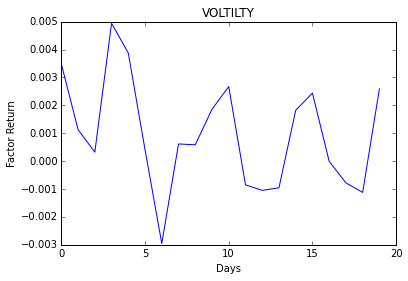

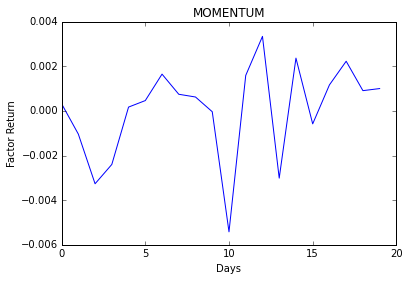

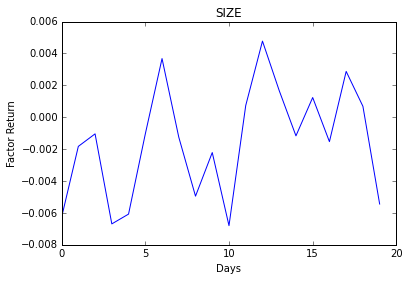

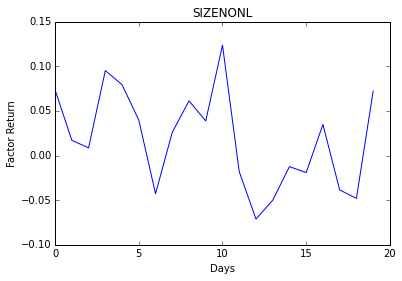

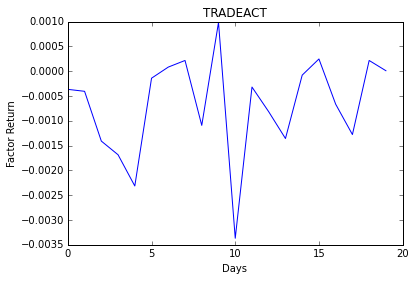

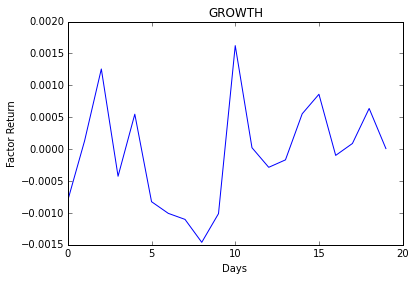

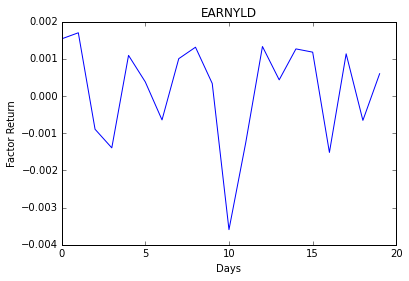

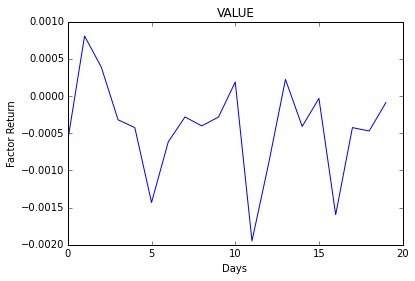

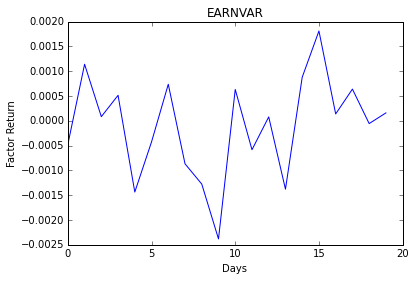

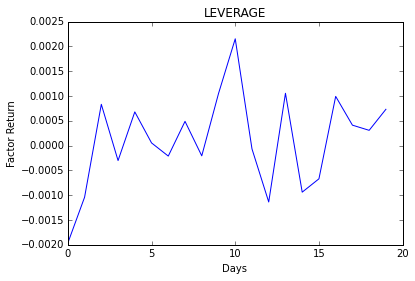

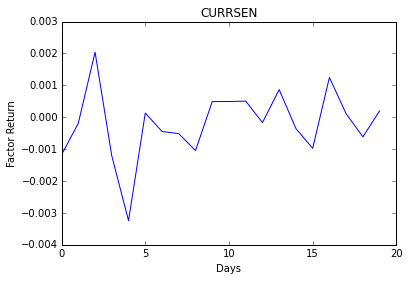

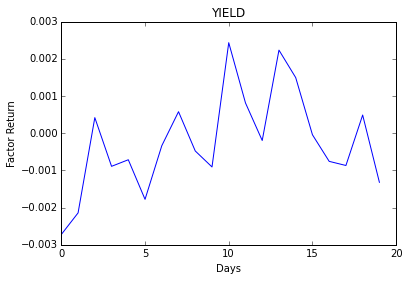

In [32]:
for factor in WLS_factor_returnDF:
    plt.figure()
    plt.plot(WLS_factor_returnDF[factor])
    plt.title(factor)
    plt.xlabel("Days")
    plt.ylabel("Factor Return")
    

In [33]:
for day in sorted(WLS_results):
    print(day)
    print(WLS_results[day].summary())

20130904
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.447
Model:                            WLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     40.02
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           1.38e-68
Time:                        19:08:38   Log-Likelihood:                 1905.0
No. Observations:                 606   AIC:                            -3786.
Df Residuals:                     594   BIC:                            -3733.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0035      0.001      4.453

#### Method Two: 

In [34]:
log_resi_var = np.log(OLS_residues**2)

In [35]:
residual_var_pred = sm.add_constant(factors_trim.values) # add constant term in regression
OLS_resi_var_result = np.linalg.lstsq(residual_var_pred, log_resi_var) 

In [36]:
OLS_resi_var_result[0].shape #P * T

(13, 20)

In [37]:
#fitted value, take exp, then average over days
var_est2 = np.mean(np.exp(residual_var_pred.dot(OLS_resi_var_result[0])), axis = 1)

In [38]:
var_est2.shape

(606,)

In [39]:
WLS_weights2 = 1/var_est2
WLS_results2 = {}
for row in returnDF.iterrows(): #row[1] is the Series, row[0] is the row name
    WLS_model2 = sm.WLS(row[1].values, factors_trim.values, weights = WLS_weights2)
    WLS_results2[row[0]] = WLS_model2.fit()
    
WLS_factor_return2 = {day: WLS_results2[day].params for day in WLS_results2}
WLS_factor_returnDF2 = pd.DataFrame(data = WLS_factor_return2, index = factors_trim.columns).T

In [40]:
WLS_factor_returnDF2

,VOLTILTY,MOMENTUM,SIZE,SIZENONL,TRADEACT,GROWTH,EARNYLD,VALUE,EARNVAR,LEVERAGE,CURRSEN,YIELD
20130904,0.004684,0.000066,-0.005439,0.075282,0.000485,-0.000612,0.001378,-0.000299,-0.000699,-0.002434,-0.001006,-0.002444
20130905,0.001199,-0.001176,-0.002601,0.018207,-0.000439,-0.000116,0.001170,0.000868,0.001771,-0.000944,0.000142,-0.002049
20130906,0.001275,-0.003542,-0.000969,0.010108,-0.001886,0.001542,-0.000705,0.000228,-0.000428,0.001252,0.002272,0.000648
20130909,0.008027,-0.001262,-0.005898,0.093891,-0.002209,-0.000762,-0.002677,-0.000756,0.001340,-0.002937,-0.002014,0.002208
20130910,0.003607,0.000388,-0.004909,0.078294,-0.002247,0.000417,0.000913,0.000130,-0.001423,0.000630,-0.002950,-0.001228
20130911,0.000467,0.000360,-0.000891,0.033975,-0.000316,-0.001530,0.000346,-0.001054,-0.001324,-0.000024,-0.000100,-0.002349
20130912,-0.002281,0.001320,0.003555,-0.040224,0.000089,-0.001174,-0.000750,-0.000633,0.000571,-0.000859,-0.000735,-0.000227
20130913,0.001073,0.000914,-0.001212,0.025890,0.000072,-0.001299,0.001681,-0.000531,-0.001111,0.000451,0.000275,0.000843
20130916,0.000948,0.000810,-0.004805,0.059473,-0.001053,-0.001649,0.001412,-0.000552,-0.001464,-0.000178,-0.001085,-0.000813
20130917,0.001480,-0.000478,-0.002403,0.039735,0.000808,-0.000209,0.000101,-0.000364,-0.001993,0.000996,-0.000238,-0.001368


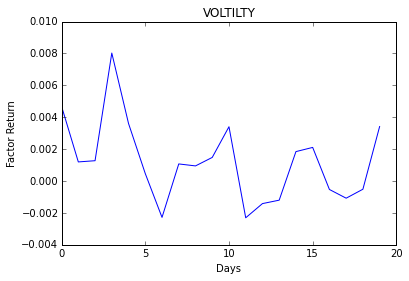

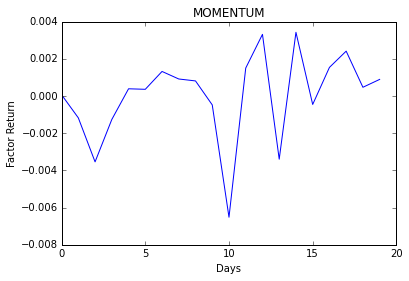

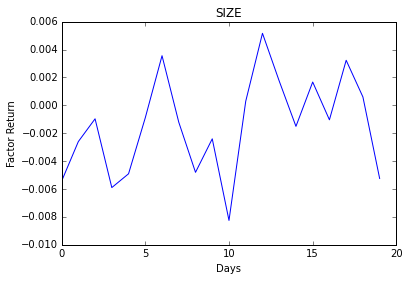

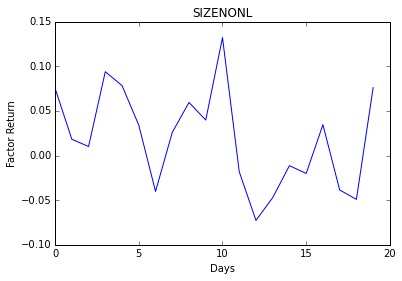

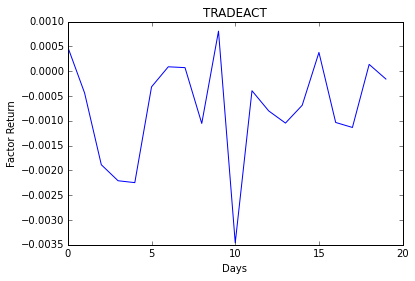

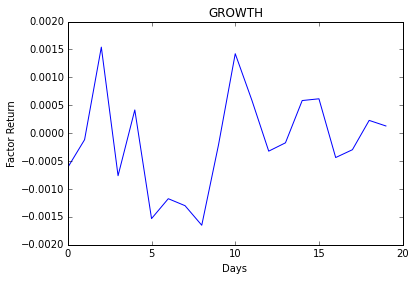

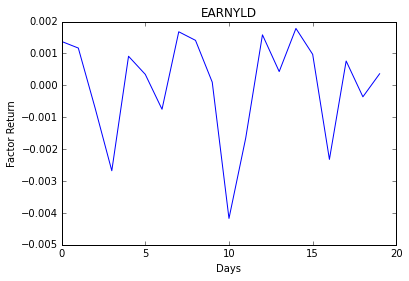

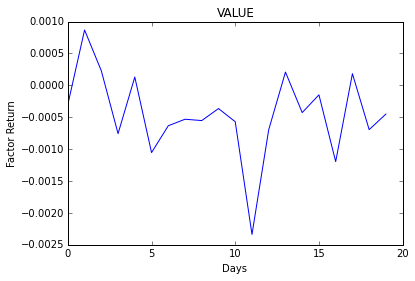

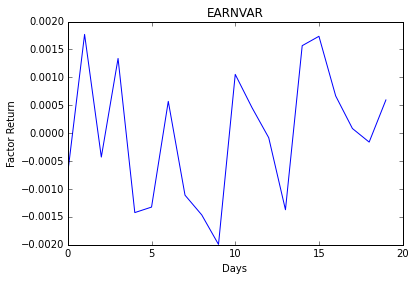

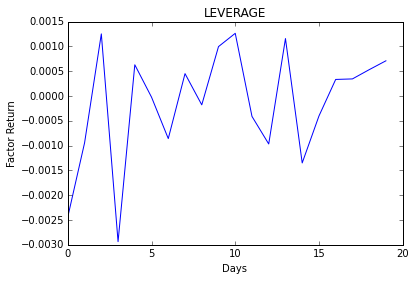

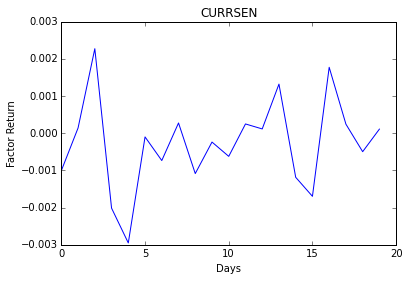

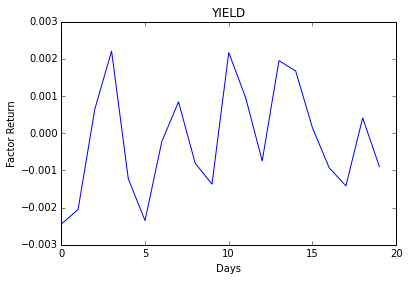

In [41]:
for factor in WLS_factor_returnDF2:
    plt.figure()
    plt.plot(WLS_factor_returnDF2[factor])
    plt.title(factor)
    plt.xlabel("Days")
    plt.ylabel("Factor Return")

In [42]:
for day in sorted(WLS_results2):
    print(day)
    print(WLS_results2[day].summary())

20130904
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.340
Model:                            WLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     25.45
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           2.94e-46
Time:                        19:08:50   Log-Likelihood:                 1820.9
No. Observations:                 606   AIC:                            -3618.
Df Residuals:                     594   BIC:                            -3565.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0047      0.001      4.644